In [42]:
### imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error


import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.regression import * # models
# preprocessing
from src.datahandling.preprocessing import * 
from sklearn.kernel_approximation import Nystroem


### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# Regression Variants

Regression is a supervised learning algorithm that tries to find a (linear) relationship between a dependent variable and one or more independent variables by solving an optimization problem. In contrast to the _Moving Average_ model we are able to exploit additional variables in the datasets, such as wind speed. Within this project we tested the following regression variants:

1. __Ridge Regression__

3. __Kernel Ridge Regression__:

Please find a description of the regression variants in their respective sections. 
Each section follows a consistent structure, with the only variation being specific to the analysis. First, we conduct a grid search across the hyperparameter space. Subsequently, we plot and analyse the results. At the end of each section, we retrain the top-performing models and examine how their predictions compare to the actual ground truth values.

We begin with loading the data:


#### Data Loading 

In [2]:
### loading british data
TURBINE_ID_BRIT = 2 
data_british = load_data(turbine_id=TURBINE_ID_BRIT, which_data="British")#

### loading brazilian data
TURBINE_ID_BRAZ = 1
data_braz = load_data(turbine_id=TURBINE_ID_BRAZ, which_data="Brazilian")

### cleaning british data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Nacelle position (°)",
        "Nacelle ambient temperature (°C)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "nacelle_position",
        "nacelle_temp",
        "rotor_speed",
    ],
)
data_british = cleaner.transform(data_british)

### cleaning brazilian data
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
        "air_density",
        "relative_humidity",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
        "air_density",
        "relative_humidity",
    ],
)
data_braz = cleaner.transform(data_braz)

Also we can define the final test and training datasets beforehand:

In [3]:
### create train and test set for british dataset (exactly as used in the benchmarks)
test_start_brit = benchmarks["test_start"][0]
test_end_brit = benchmarks["test_end"][0]
X_train_brit, y_train_brit, X_test_brit, y_test_brit = train_test_split(
    df=data_british, test_start=test_start_brit, test_end=test_end_brit, target_var="power"
)

### create train and test set for brazilian data (exactly as used in the benchmarks)
test_start_braz = benchmarks["test_start"][3]
test_end_braz = benchmarks["test_end"][3]
X_train_braz, y_train_braz, X_test_braz, y_test_braz = train_test_split(
    df=data_braz, test_start=test_start_braz, test_end=test_end_braz, target_var="power"
)

## Ridge Regression

The ridge regression model adds a regularization term to the L2-loss function. The regularization term is defined as the L2-norm of the weight vector $\omega$. So we have the following optimization problem:

$$
\min_{\omega} ||Y - X\omega||^2 + \alpha ||\omega||^2
$$

We can solve this optimization problem in closed form:

$$
\omega = (X^TX + \alpha I)^{-1}X^TY
$$

The hyperparameter $\alpha$ controls the strength of the regularization. The higher $\alpha$ the stronger the regularization. The regularization term is used to prevent overfitting. The magnitude of alpha depends on the scale of the features. Therefore, we scale the features before applying ridge regression.

Note, that in this set-up exists a trade-off between the window_size of the SupervisedTransformer and the regularization parameter $\alpha$. The larger the window_size the more features we have and the more regularization we need to prevent overfitting. That is why the hyperparameter space of $\alpha$ is dependent on the window_size.

This leads us to the following model and hyperparameter space:


In [4]:
### Define model
model = Pipeline(
    [
        ("scale", Normalizer()),
        # we scale the data to ensure that the regularization parameter alpha is comparable across different features
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("est", RidgeRegression()),
    ]
)

### Define the hyperparameter grid
param_grid = [
    {
    "st__horizon": ["10min", "hourly", "daily"],
    "st__window_size": [1, 2, 3],
    "est__alpha": [0.1, 1, 10, 100],
    },
    {
    "st__horizon": ["10min", "hourly", "daily"], 
    "st__window_size": [4, 6, 8], 
    "est__alpha": [1, 10, 100, 1000],
    },
]

### British Dataset - Kelmarsh

In [5]:
### hyperparameter tuning
### RUNTIME: ~ 1.5 min 
do_gridsearch = False

if do_gridsearch:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=1,
        n_jobs=-1,
        refit=False,
    )
    grid_search.fit(X_train_brit, y_train_brit)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_rr_brit.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_brit = pd.read_csv("../results/results_gs_rr_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_rr_brit.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


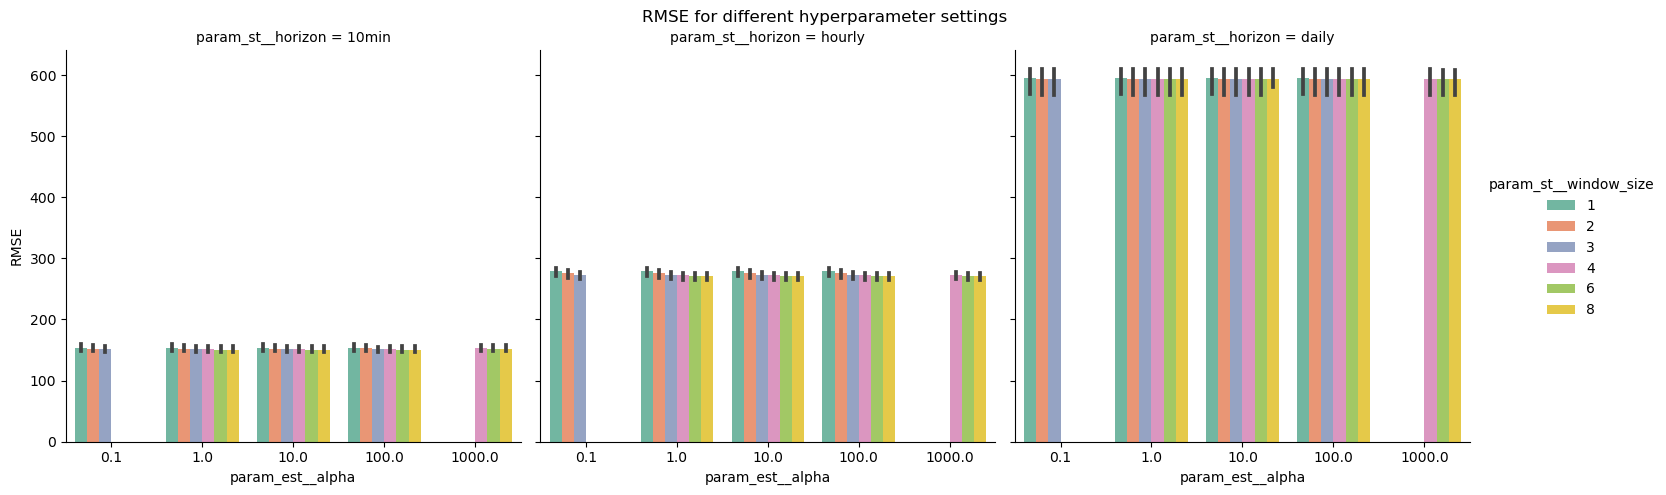

In [6]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_brit, x="param_est__alpha", hue="param_st__window_size", col="param_st__horizon"
)

__Analysis:__

In the plot above, it's evident that the model exhibits remarkable stability across the explored range of hyperparameters. Both the window size and the regularization parameter $\alpha$ appear to exert minimal influence on the model's performance.

A subtle tendency towards larger window sizes and higher regularization values can be observed. Nonetheless, these variations are so negligible that they can be considered inconsequential. In this context, _Ridge Regression_ proves to be an exceptionally robust model, allowing for considerable flexibility in hyperparameter selection.

In [7]:
### extract best parameters of each model for each horizon
best_params_brit_rr = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_rr.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_rr.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'est__alpha': 10, 'st__horizon': '10min', 'st__window_size': 8}
Best parameters for horizon daily: {'est__alpha': 1000, 'st__horizon': 'daily', 'st__window_size': 8}
Best parameters for horizon hourly: {'est__alpha': 10, 'st__horizon': 'hourly', 'st__window_size': 8}


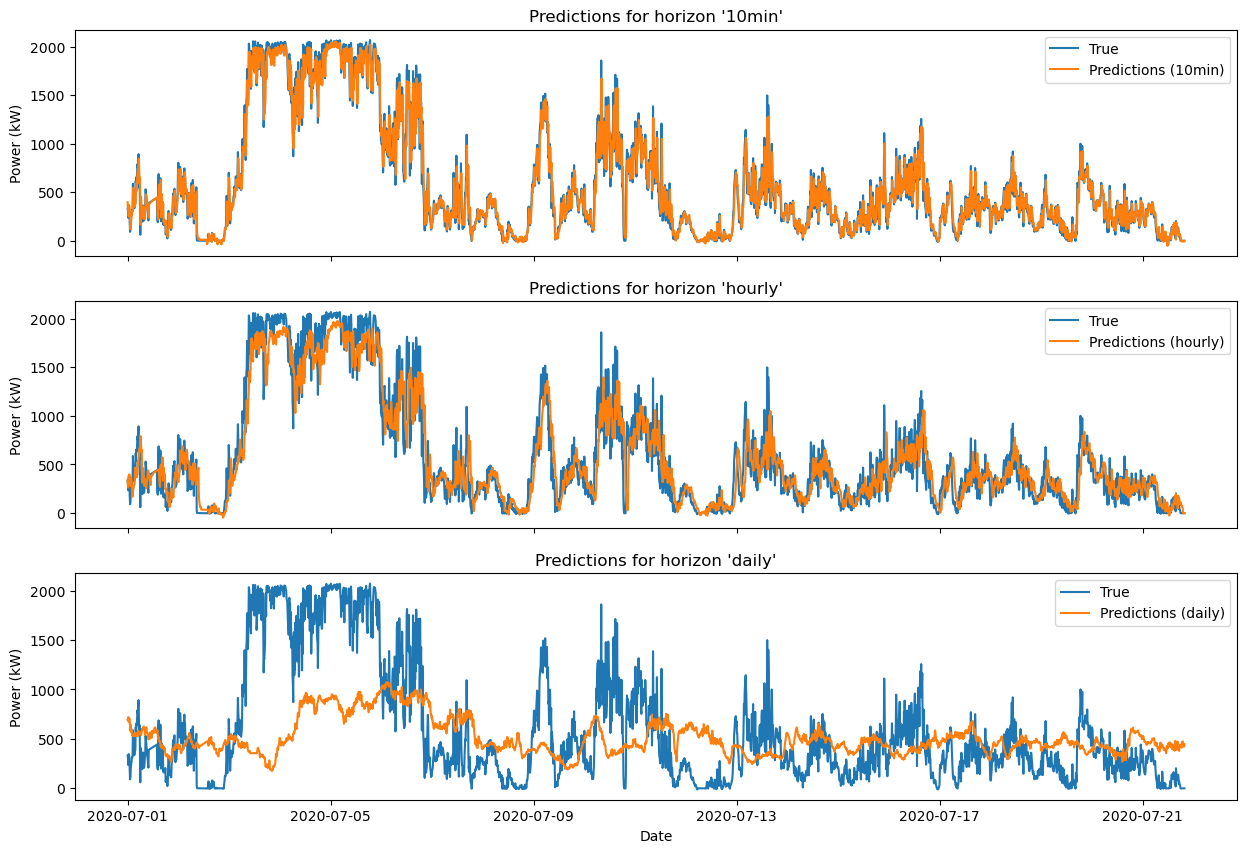

In [8]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit_rr.loc[horizon][0])
    )
    models[horizon].fit(X_train_brit, y_train_brit)
    predictions[horizon] = models[horizon].predict(X_test_brit)
predictions = pd.DataFrame(predictions, index=X_test_brit.index)

# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[:3000],
    y_test_brit.iloc[:3000],
)

__Analysis:__

The plots resemble the ones from the _Moving Average_ model. 

- For a forecasting horizon of 10 minutes, the model is able to predict the ground truth values very well. If we choose fewer data points, we see that the model appears to have also a shift by exactly one time steps. In contrary to the _Moving Average_ model, this behaviour is not there by design of the model. 

- The _Ridge Regression_ model also shows similar results to the ones provided by the _Moving Average_. The model predicts the general structure of the ground truth values well, but does not capture sudden peaks or troughs.

- When looking at a one-day forecasting period, the _Ridge Regression_ model shows the most significant deviation from the _Moving Average_ model. It provides a very conservative estimate of the overall trend but falls short of generating a smooth curve. However, the _Ridge Regression_ model does not seem to have a such a big time delay in predicting peaks and troughs.

In [9]:
### extract coefficients of first two models
# and check if there are any close to zero

# horizon = 10min
print(models["10min"]["est"].coef_ > 1e-10)

# horizon = hourly
print(models["hourly"]["est"].coef_ > 1e-10)

# horizon = daily
print(models["daily"]["est"].coef_ > 1e-10)

X_train_brit.columns, len(models["10min"]["est"].coef_)

[ True  True  True  True  True  True  True  True  True False False False
 False False  True False  True False  True False False False  True False
  True  True False False  True False  True  True  True False  True  True
 False  True  True False  True False  True False False False False False
 False  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True False
 False  True  True False False False False False  True False  True False
 False False  True False  True  True  True False  True False False False
 False  True False False  True False False False False False False False
 False  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False  True  True  True  True False False
 False False  True  True False False False False False False False False
 False  True  True  True]


(Index(['power', 'wind_speed', 'wind_direction', 'nacelle_position',
        'nacelle_temp', 'rotor_speed'],
       dtype='object'),
 52)

Several features in the dataset exhibit extremely low coefficients. Notably, the last 12 to 4 features correspond to the rotor speed variable, which frequently demonstrates coefficients below $10^{-10}$. In contrast, for the remaining features, no recognizable pattern emerges. Also interestingly, the three out of four coefficients belongig to the time features (last 4) are larger than the threshold and therefore seem to be relevant.

### Brazilian Dataset - Beberibe

In [11]:
### hyperparameter tuning
### RUNTIME: ~ 30 seconds
do_gridsearch = False

if do_gridsearch:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=1,
        n_jobs=-1,
        refit=False,
    )

    grid_search.fit(X_train_braz, y_train_braz)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_rr_braz.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_braz = pd.read_csv("../results/results_gs_rr_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_rr_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


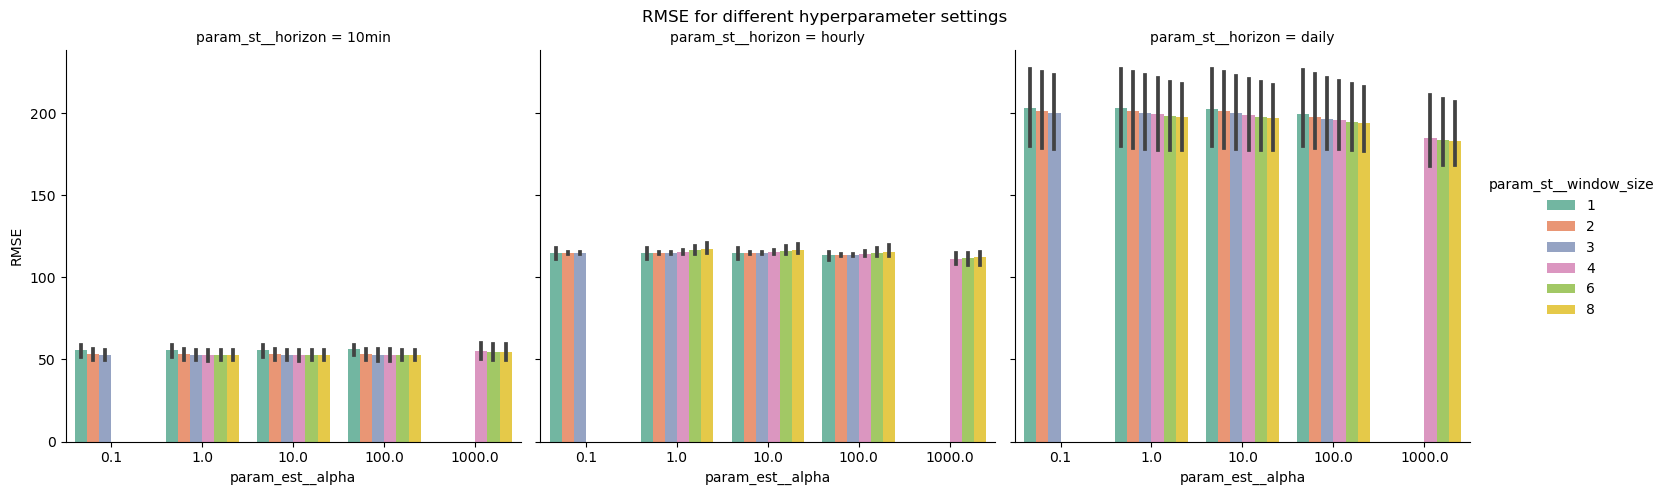

In [12]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_braz, x="param_est__alpha", hue="param_st__window_size", col="param_st__horizon"
)

__Analysis:__

A similar pattern emerges as seen in the British dataset. The model maintains remarkable stability across the range of hyperparameters we investigated. When it comes to daily forecasting, the plot displays considerable variance (higher than for the British data), indicating that the model's performance varies significantly across different folds. This yields the assumption that for the task of performing a daily forecast much more trainings data is required. 

In [13]:
### extract best parameters of each model for each horizon
best_params_braz_rr = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_rr.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_rr.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'est__alpha': 10, 'st__horizon': '10min', 'st__window_size': 4}
Best parameters for horizon daily: {'est__alpha': 1000, 'st__horizon': 'daily', 'st__window_size': 8}
Best parameters for horizon hourly: {'est__alpha': 1000, 'st__horizon': 'hourly', 'st__window_size': 4}


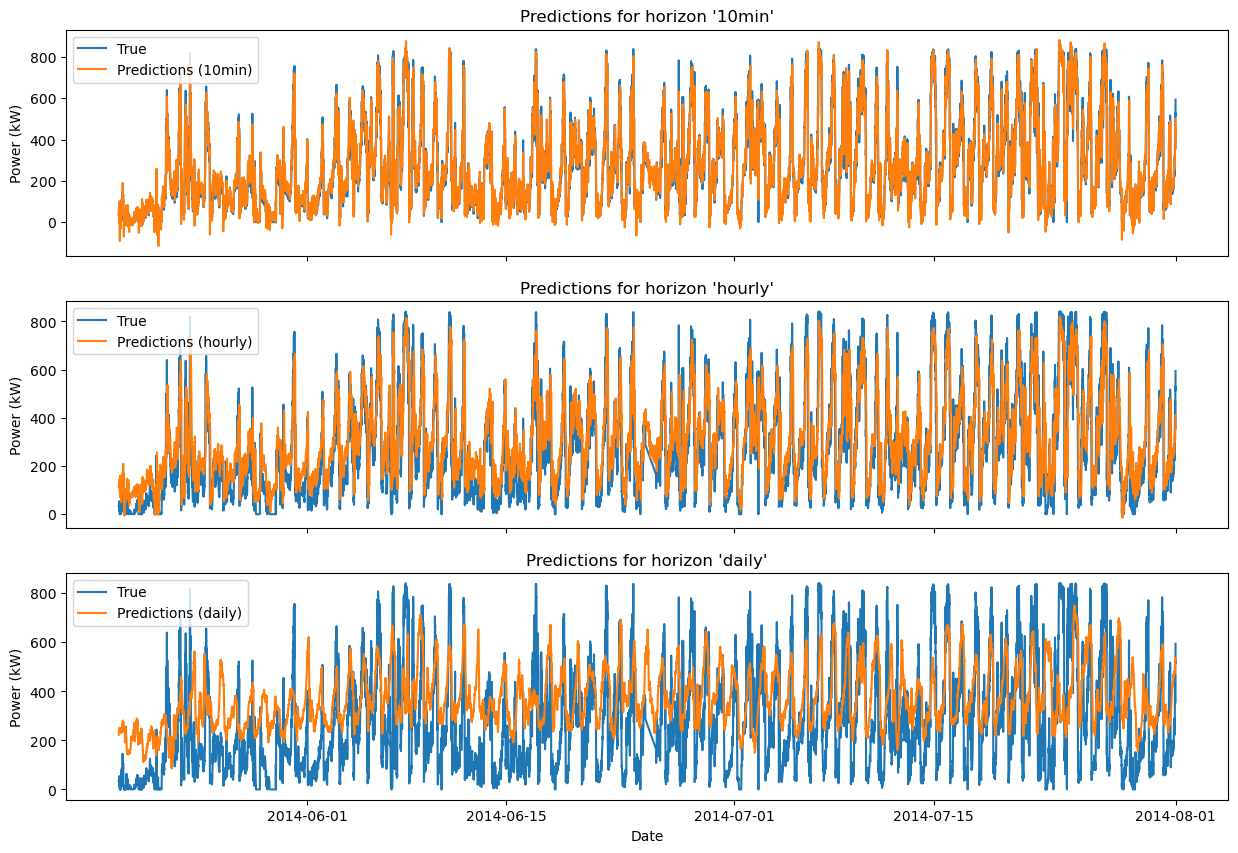

In [14]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_rr.loc[horizon][0])
    )
    models[horizon].fit(X_train_braz, y_train_braz)
    predictions[horizon] = models[horizon].predict(X_test_braz)
predictions = pd.DataFrame(predictions, index=X_test_braz.index)

# plotting_braz
vis.plot_predictions(predictions, y_test_braz)

We can see similar visual results as for the British dataset.

## Kernel Ridge Regression

The _Kernel Ridge Regression_ algorithm extends basic _Ridge Regression_ by using the kernel trick. The kternel trick allows us to implicitly map the input data into a higher dimensional feature space and thus to capture non-linear relationships. That is why we did not transform the data with the Polynomial feature transformer in the _Ridge Regression_. 

Mapping is done by defining a kernel function $k(x, x')$ that computes the inner product of the mapped feature vectors $\phi(x)$ and $\phi(x')$:

$$
k(x, x') = \phi(x)^T\phi(x')
$$

The kernel trick allows us to avoid the explicit computation of $\phi(x)$ and $\phi(x')$. Here we will use the _Gaussian Kernel_:

$$
k(x, x') = \exp(-\gamma||x - x'||^2)
$$

The optimization problem of _Kernel Ridge Regression_ is defined as follows:

$$
\min_{\omega} ||Y - \Phi\omega||^2 + \lambda ||\omega||^2
$$

where $\Phi$ is the kernel matrix with $\Phi_{ij} = k(x_i, x_j)$.

__Remarks to the computational complexity:__

The computational complexity of the _Kernel Ridge Regression_ is $O(m^2n)$, where $m$ is the number of features and $n$ is the number of samples. In our case this is a problem since we have a large number of samples. We use the Nystroem method to approximate the kernel matrix $\Phi$. 



In [15]:
### Define model
model = Pipeline(
    [
        ("scale", Normalizer()),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("nystroem", Nystroem(n_jobs=-1)),
        ("est", RidgeRegression()),
    ]
)

### Define the hyperparameter grid
param_grid = {
    "st__horizon": ["10min", "hourly", "daily"],
    "st__window_size": [8],
    "nystroem__kernel": ["rbf", "linear"],
    "nystroem__n_components": [100, 500, 1000],
}

### British Dataset - Kelmarsh

In [16]:
### hyperparameter tuning
### RUNTIME: ~ 20 min
do_gridsearch = False

if do_gridsearch:

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        refit=False,
    )

    grid_search.fit(X_train_brit, y_train_brit)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_kernel_brit.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_brit = pd.read_csv("../results/results_gs_kernel_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_kernel_brit.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


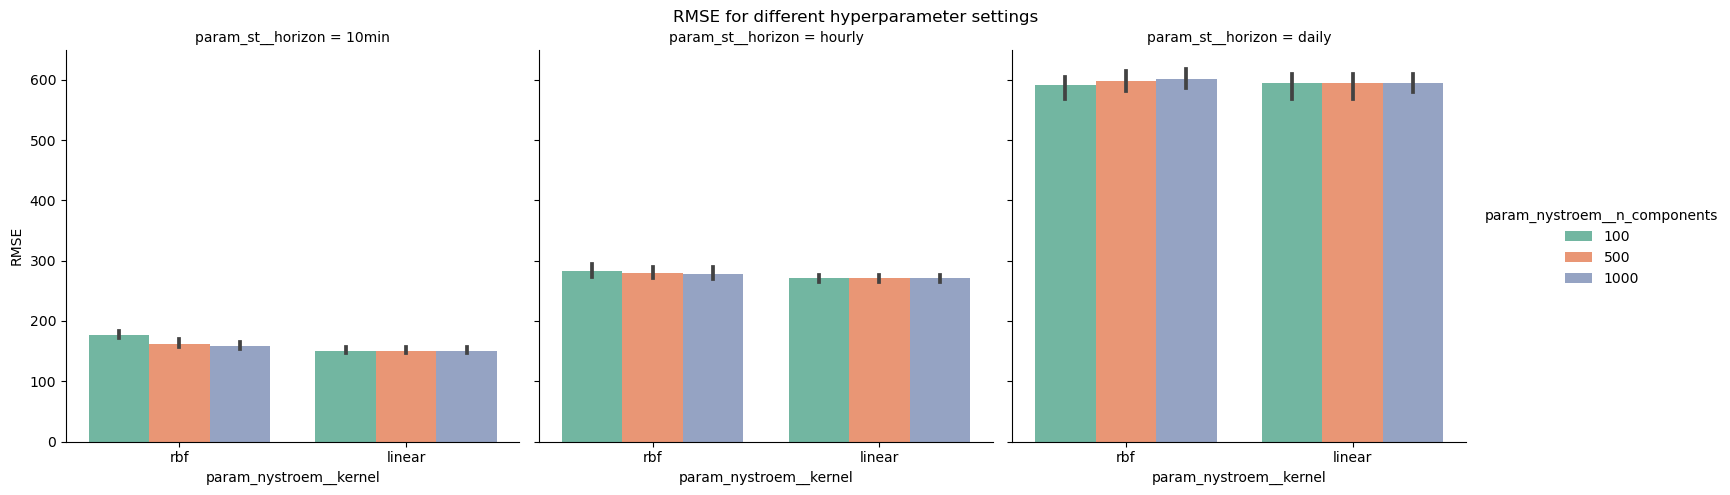

In [17]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_brit, x="param_nystroem__kernel", hue="param_nystroem__n_components", col="param_st__horizon",
)

__Analysis:__

We can observe remarkably similar outcomes akin to those of the _Ridge Regression_ model. The model shows a notable stability throughout the explored hyperparameter range. This observation holds a touch of surprise considering the large variance in the dimensionality of the Nystroem approximation across the explored space.

Furthermore, the magnitudes of the RMSE values closely align with those of the Ridge Regression model.


In [18]:
### extract best parameters of each model for each horizon
best_params_brit_kernel = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_kernel.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_kernel.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'nystroem__kernel': 'linear', 'nystroem__n_components': 500, 'st__horizon': '10min', 'st__window_size': 8}
Best parameters for horizon daily: {'nystroem__kernel': 'rbf', 'nystroem__n_components': 100, 'st__horizon': 'daily', 'st__window_size': 8}
Best parameters for horizon hourly: {'nystroem__kernel': 'linear', 'nystroem__n_components': 100, 'st__horizon': 'hourly', 'st__window_size': 8}


In [19]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit_kernel.loc[horizon][0])
    )
    models[horizon].fit(X_train_brit, y_train_brit)
    predictions[horizon] = models[horizon].predict(X_test_brit)
predictions = pd.DataFrame(predictions, index=X_test_brit.index)


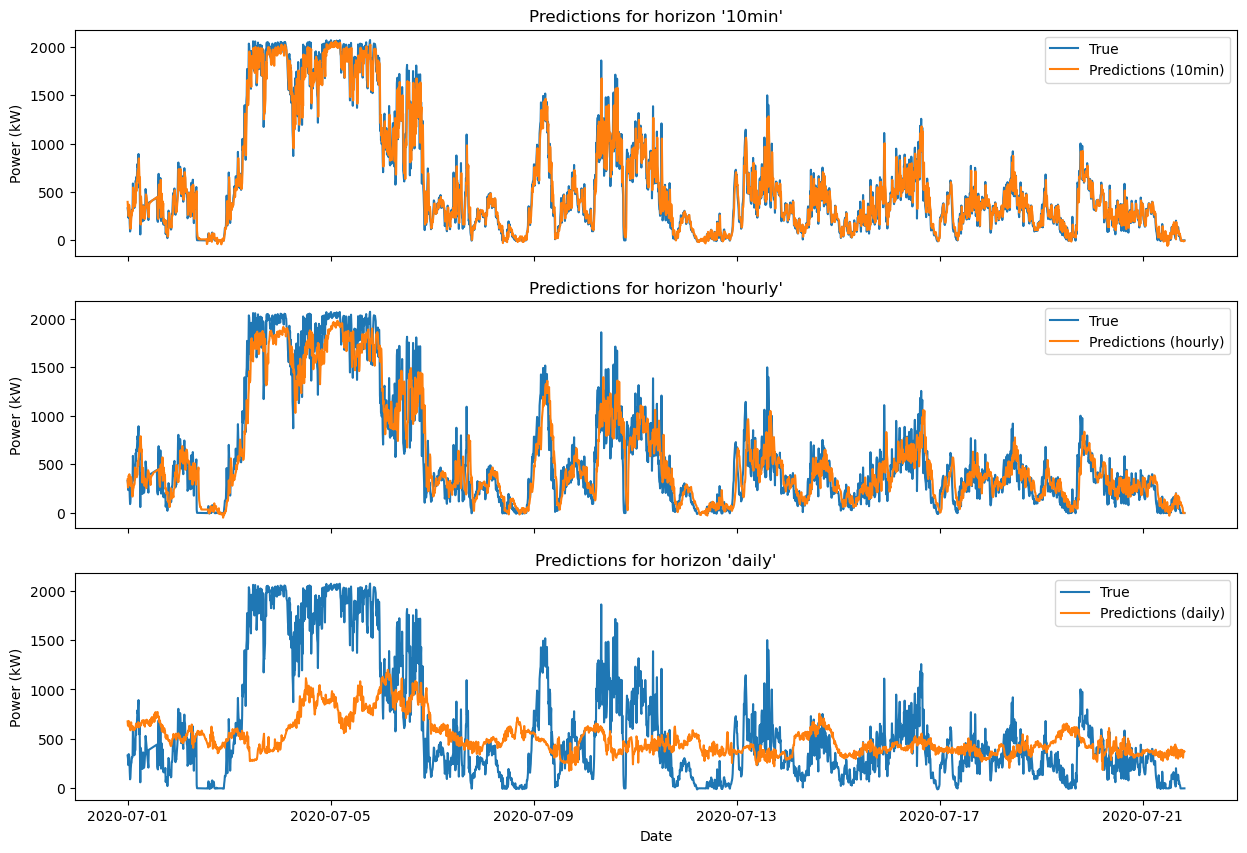

In [20]:
# plotting
vis.plot_predictions(predictions.iloc[:3000], y_test_brit.iloc[:3000])

__Analysis:__

The plots resemble the ones from the _Ridge Regression_ model.

### Brazilian Dataset - Beberibe

In [21]:
### hyperparameter tuning
### RUNTIME: ~ 9 min
do_gridsearch = False

if do_gridsearch:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=1,
        n_jobs=-1,
        refit=False,
    )

    grid_search.fit(X_train_braz, y_train_braz)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_kernel_braz.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_braz = pd.read_csv("../results/results_gs_kernel_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_kernel_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


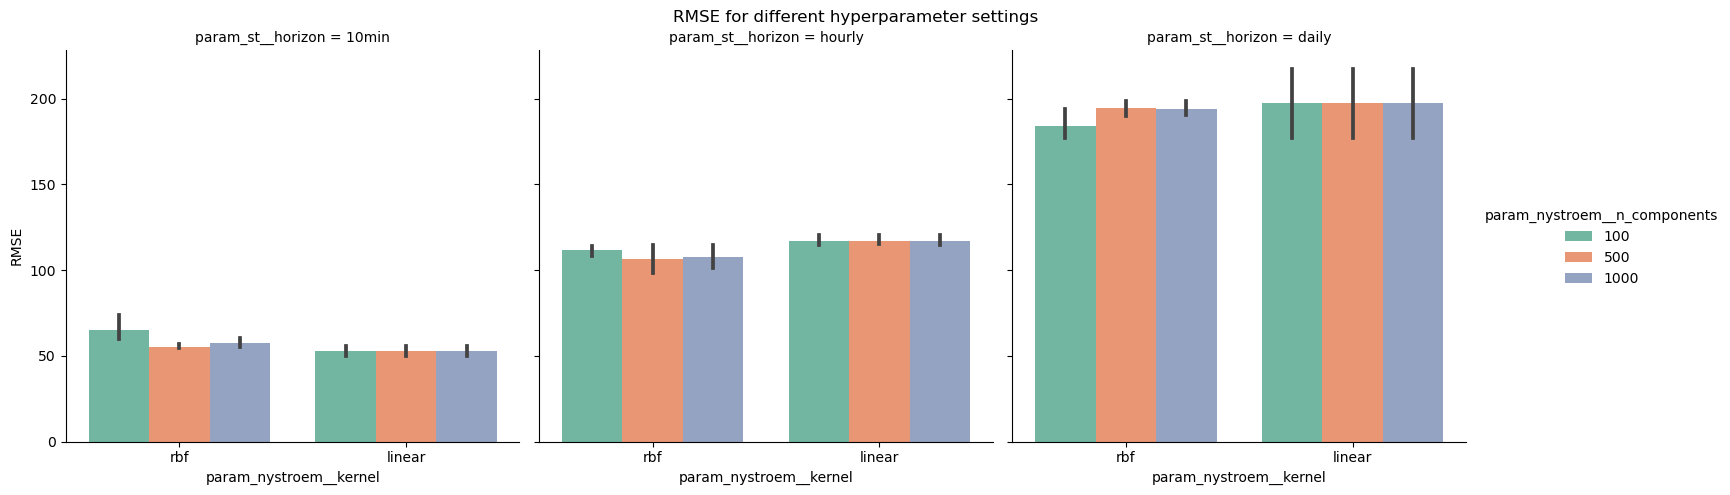

In [22]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_braz, x="param_nystroem__kernel", hue="param_nystroem__n_components", 
)

__Analysis:__

Again, we get a remarkably stability across the explored hyperparameter space. Essentially, we can see the same as for the British dataset.

In [23]:
### extract best parameters of each model for each horizon
best_params_braz_kernel = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_kernel.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_kernel.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'nystroem__kernel': 'linear', 'nystroem__n_components': 100, 'st__horizon': '10min', 'st__window_size': 8}
Best parameters for horizon daily: {'nystroem__kernel': 'rbf', 'nystroem__n_components': 100, 'st__horizon': 'daily', 'st__window_size': 8}
Best parameters for horizon hourly: {'nystroem__kernel': 'rbf', 'nystroem__n_components': 500, 'st__horizon': 'hourly', 'st__window_size': 8}


In [24]:
### plot predictions for best models

# refitting
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_kernel.loc[horizon][0])
    )
    models[horizon].fit(X_train_braz, y_train_braz)
    predictions[horizon] = models[horizon].predict(X_test_braz)
predictions = pd.DataFrame(predictions, index=X_test_braz.index)


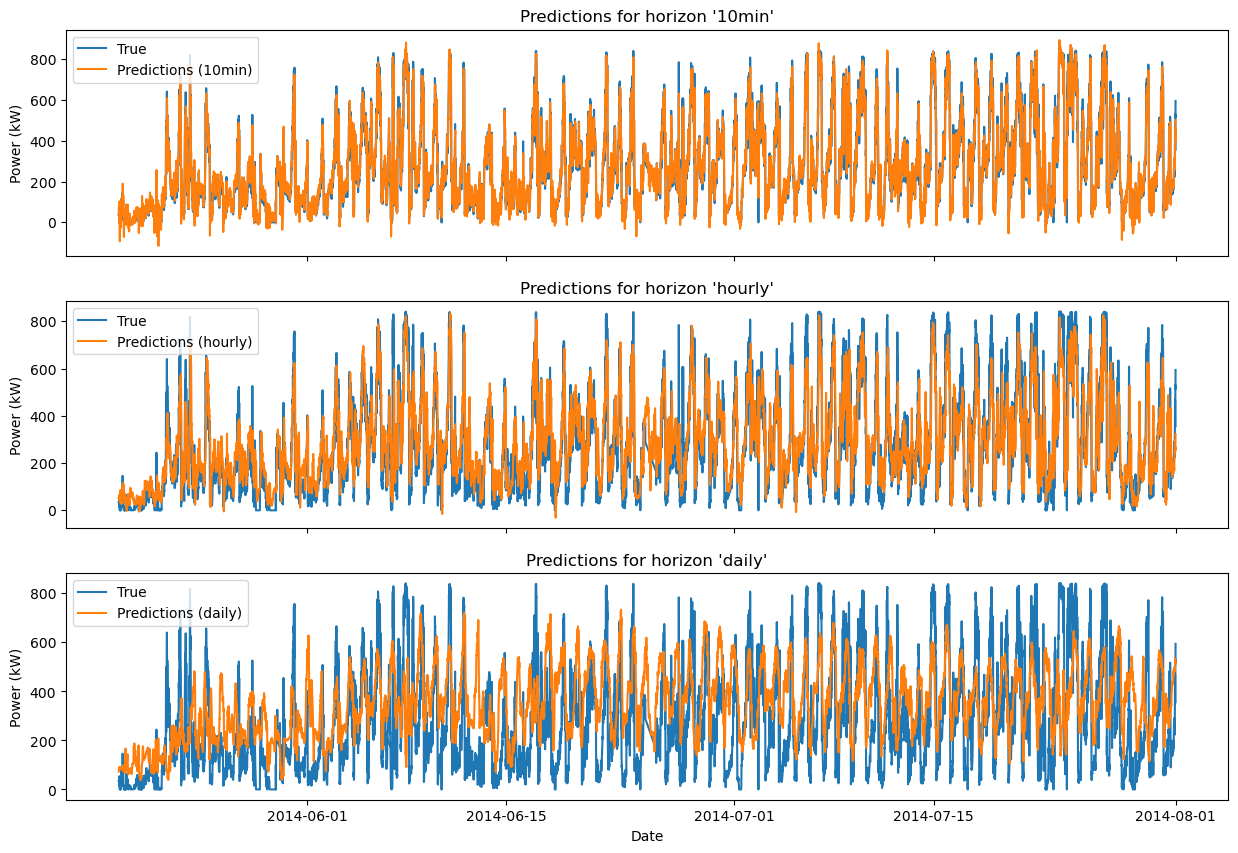

In [25]:
# plotting
vis.plot_predictions(predictions, y_test_braz)

__Analysis:__

The plots resemble the ones from the _Ridge Regression_ model.

## Transfer Learning Challenge

We do both transfer learning challenges. First, we train the model on the British dataset and then evaluate it on the Brazilian dataset. Second, we train the model on the Brazilian dataset and then evaluate it on the British dataset. Both is done for the _Ridge Regression_ and the _Kernel Ridge Regression_.


Before we continue, it's import to take the following points into account:

Incorporating cyclical time features into the model may not be appropriate, given that Brazil and Britain are located in different hemispheres, likely experiencing distinct weather patterns throughout a day and a year.

It's worth highlighting that the turbine types in the British and Brazilian datasets differ. This can be observed by comparing their power output in the subsequent plot:

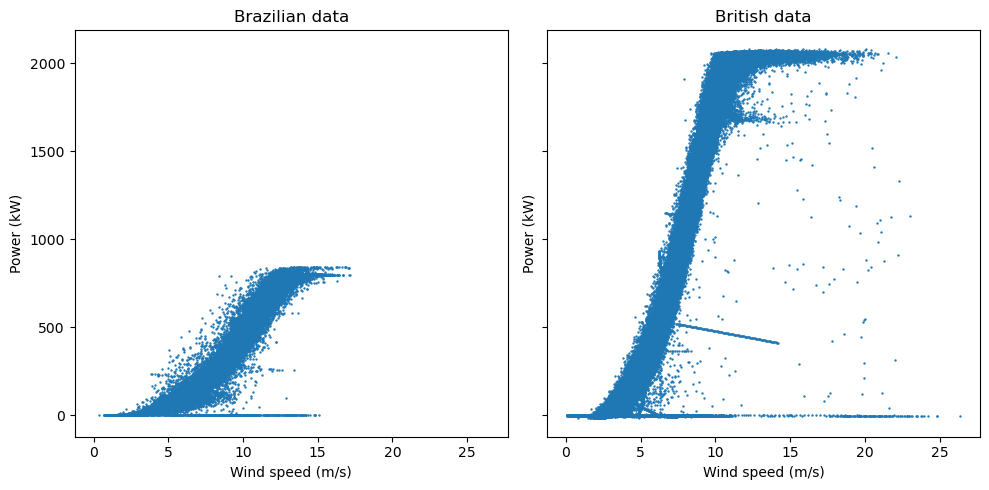

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

axs[0].scatter(data_braz["wind_speed"], data_braz["power"], s=0.5)
axs[0].set_xlabel("Wind speed (m/s)")
axs[0].set_ylabel("Power (kW)")
axs[0].set_title("Brazilian data")

axs[1].scatter(data_british["wind_speed"], data_british["power"], s=0.5)
axs[1].set_xlabel("Wind speed (m/s)")
axs[1].set_ylabel("Power (kW)")
axs[1].set_title("British data")

fig.tight_layout()


That is why we first normalize the whole data set (we take all features that are contained in both datasets). In that way also the target vector "power" is normalized and the models should be able to learn the same patterns. 

In [26]:
norm_brit = Normalizer()
norm_brit.fit(data_british)
norm_braz = Normalizer()
norm_braz.fit(data_braz)

Normalizer()

Note that the SupervisedTransformer initially forecasts the initial values from the test set using data from the training set, operating under the assumption that both the training and testing sets adhere to chronological order. Consequently, to obtain an accurate error assessment, we exclude the initial 152 values (window size + largest forecasting horizon) from consideration within the test set.

### Ridge Regression

In [27]:
### Define model
model = Pipeline(
    [
        ("fs", FeatureSelector(features=["power", "wind_speed", "wind_direction", "rotor_speed"])),
        ("st", SupervisedTransformer(window_size=8)),
        ("est", RidgeRegression(alpha=10)),
    ]
)

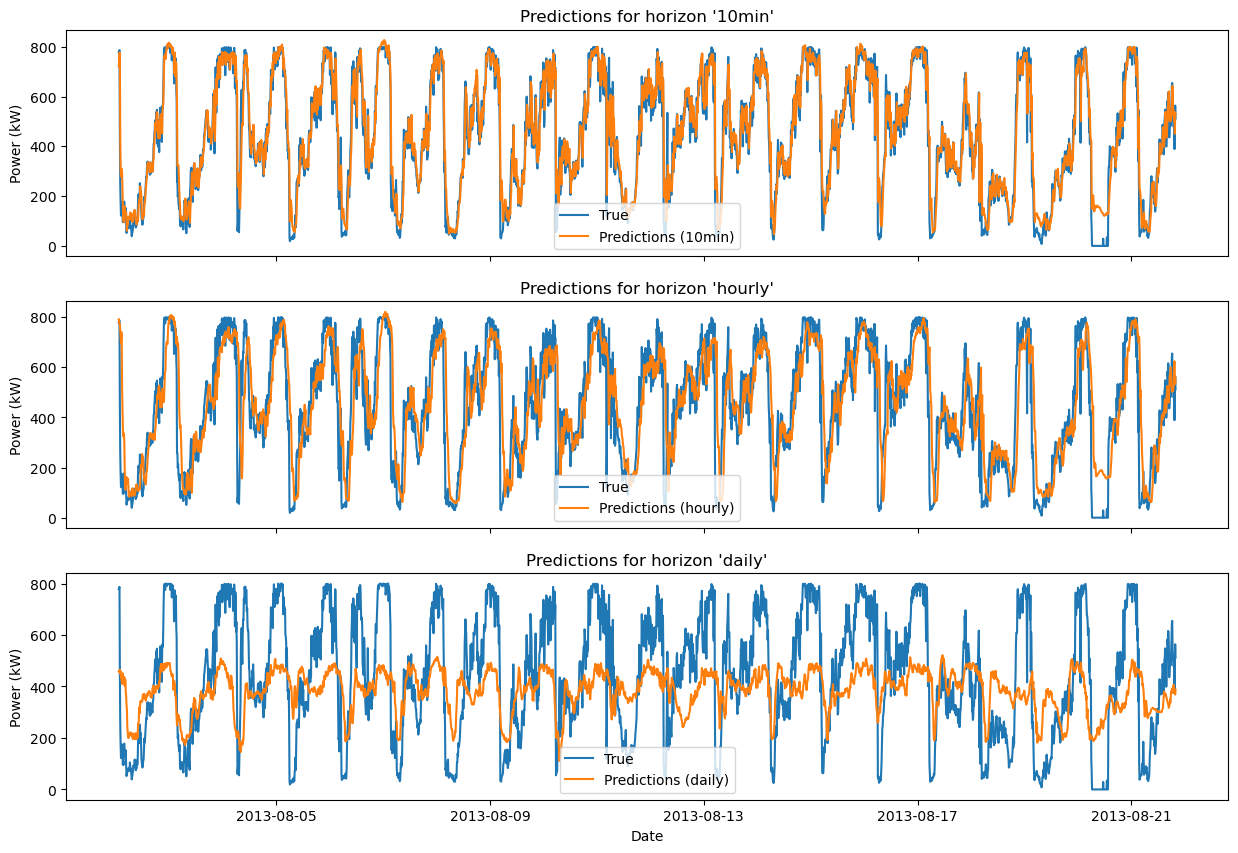

RMSE for horizon 10min: 67.61089649181348
MAE for horizon 10min: 45.9968633069352
RMSE for horizon hourly: 124.28119236861144
MAE for horizon hourly: 86.85966285163931
RMSE for horizon daily: 196.63962445917122
MAE for horizon daily: 163.49777386091517


In [45]:
### predicting brazilian from british data
X_train = norm_brit.transform(data_british)
y_train = X_train["power"]
X_test = norm_braz.transform(data_braz)
y_test = data_braz["power"] 

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_braz.scale_[0]) + norm_braz.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")


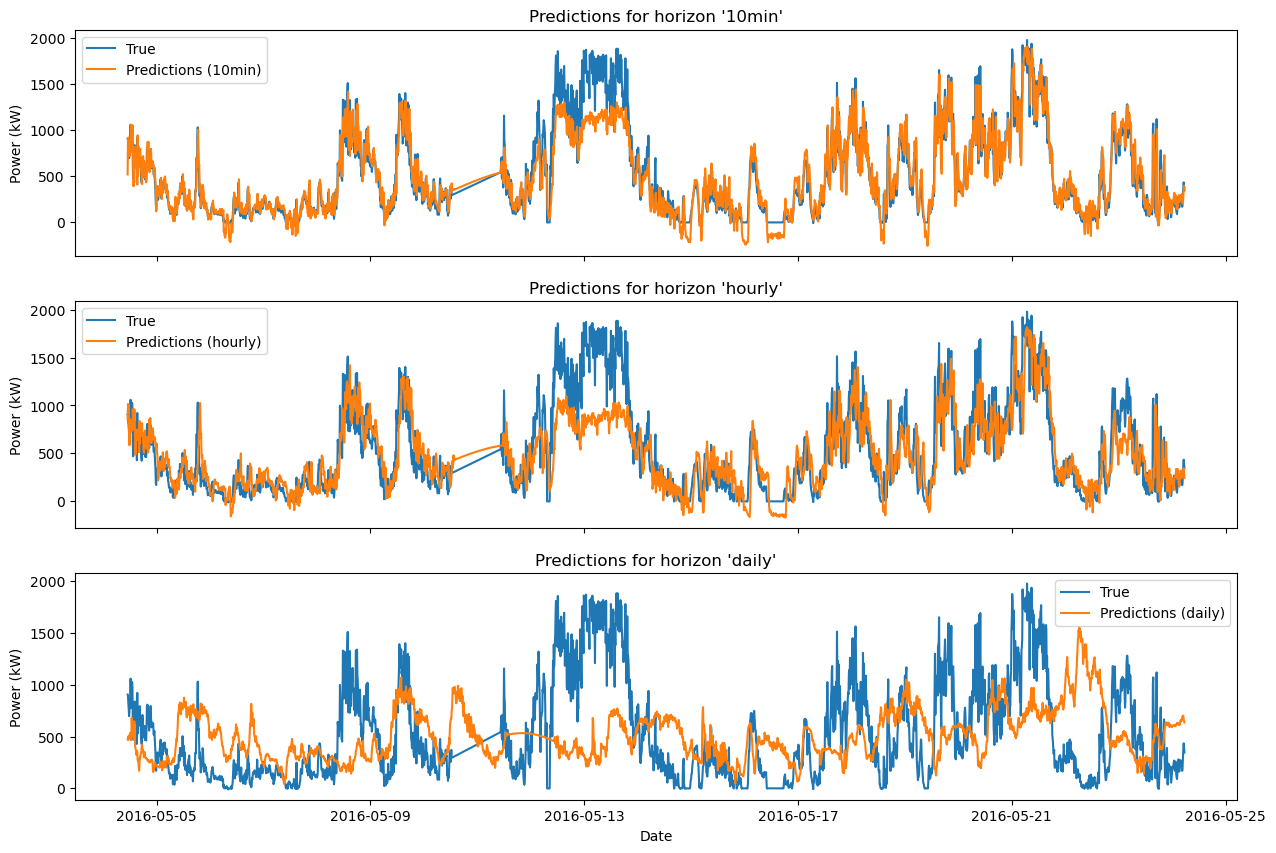

RMSE for horizon 10min: 209.8124157793372
MAE for horizon 10min: 142.9107740128908
RMSE for horizon hourly: 340.4923359656023
MAE for horizon hourly: 237.37767653638699
RMSE for horizon daily: 611.5920258088009
MAE for horizon daily: 469.3975978381893


In [46]:
### predicting british from brazilian data
X_train = norm_braz.transform(data_braz)
y_train = X_train["power"]
X_test = norm_brit.transform(data_british)
y_test = data_british["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_brit.scale_[0]) + norm_brit.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)
# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")

### Kernel Ridge Regression

In [48]:
model = Pipeline(
    [
        ("fs", FeatureSelector(features=["power", "wind_speed", "wind_direction", "rotor_speed"])),
        ("st", SupervisedTransformer(window_size=8)),
        ("nystroem", Nystroem(n_jobs=-1)),
        ("est", RidgeRegression(alpha=10)),
    ]
)

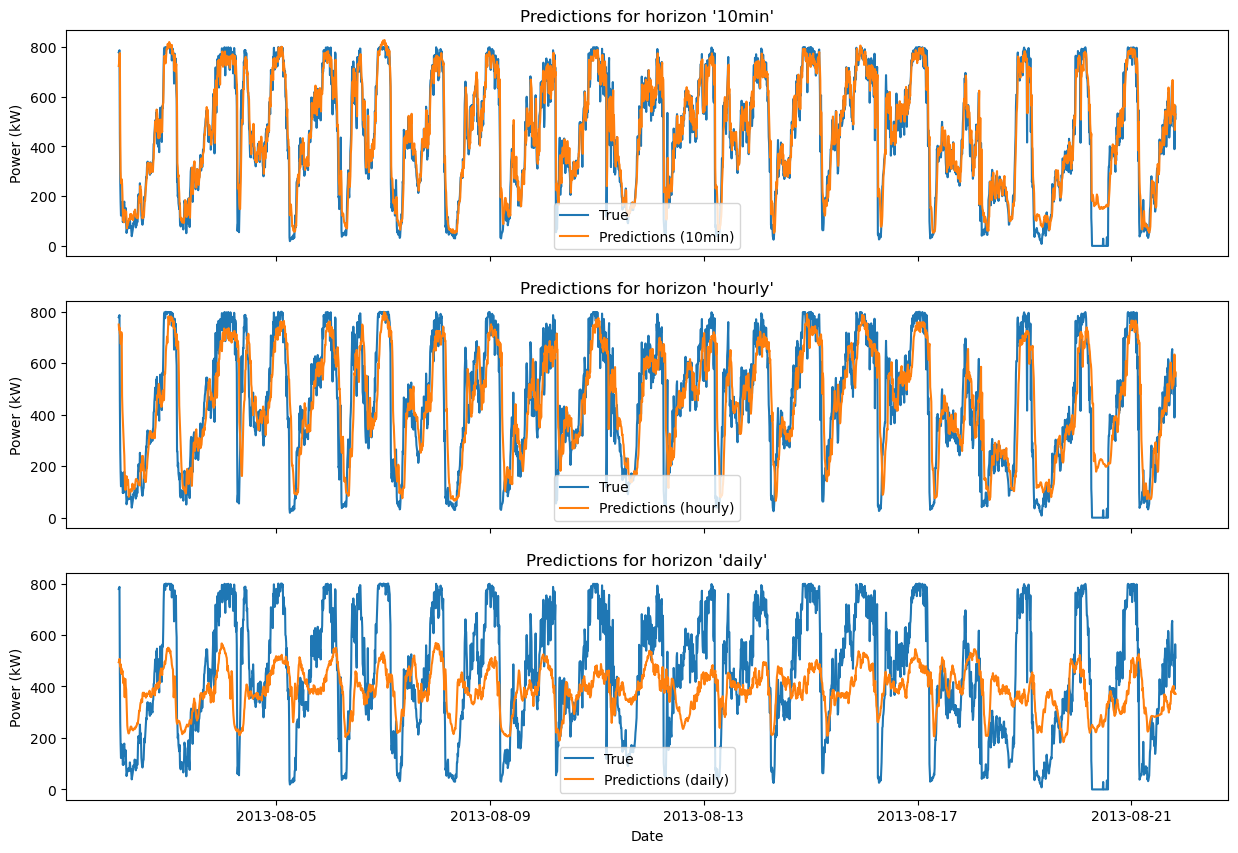

RMSE for horizon 10min: 67.40475715473379
MAE for horizon 10min: 46.0102903532887
RMSE for horizon hourly: 125.26496093158042
MAE for horizon hourly: 87.83841644764198
RMSE for horizon daily: 195.32565514113162
MAE for horizon daily: 162.71969087553236


In [49]:
### predicting brazilian from british data
X_train = norm_brit.transform(data_british)
y_train = X_train["power"]
X_test = norm_braz.transform(data_braz)
y_test = data_braz["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_braz.scale_[0]) + norm_braz.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")

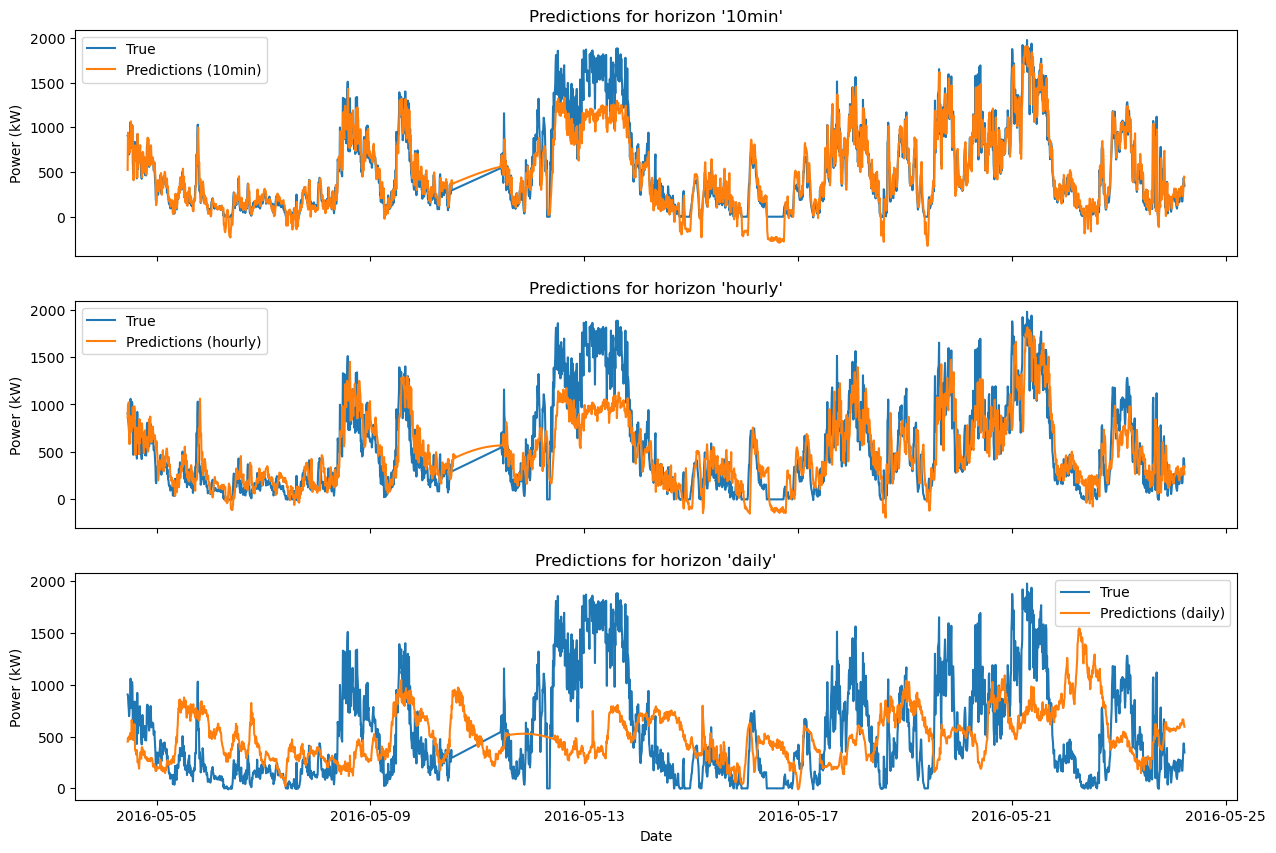

RMSE for horizon 10min: 208.55574615910194
MAE for horizon 10min: 141.2243174487604
RMSE for horizon hourly: 338.0591684624569
MAE for horizon hourly: 237.3168516982956
RMSE for horizon daily: 613.3525397560339
MAE for horizon daily: 469.70218586622565


In [50]:
### predicting british from brazilian data
X_train = norm_braz.transform(data_braz)
y_train = X_train["power"]
X_test = norm_brit.transform(data_british)
y_test = data_british["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_brit.scale_[0]) + norm_brit.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")


__Summary:__ 

All the explored transfer learning challenges work reasonably well, providing similar visual results as the ones obtained without transfer learning. RMSE and MAE are higher than in the non-transfer learning case, but given the task still in an acceptable range.